In [6]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load Data
df = pd.read_csv("../data/processed/training_data_advanced.csv")

# --- THE FIX: Convert Boolean to String before Categorical ---
df['was_home'] = df['was_home'].astype(str)  # "True", "False"

# 2. Preprocessing
cat_cols = ['position', 'opponent_team', 'was_home']
for col in cat_cols:
    df[col] = df[col].astype('category')

# 3. The Time Split
train = df[df['season'] != '2024-25'].copy()
test = df[df['season'] == '2024-25'].copy()

# Define Features and Target
features = [
    'now_cost', 'opp_def_strength_vs_pos', 'last_3_xp_delta', 'team_strength_diff',
    'mean_pts_3', 'mean_threat_3', 'mean_creativity_3', 'mean_mins_3',
    'was_home', 'position', 'opponent_team' # Ensure these are included
]
target = 'total_points'

X_train = train[features].copy()
y_train = train[target].copy()
X_test = test[features].copy()
y_test = test[target].copy()

print(f"Training Set: {X_train.shape}")
print(f"Testing Set:  {X_test.shape}")

Training Set: (106042, 11)
Testing Set:  (14178, 11)


In [7]:
# 4. Train the Brain (XGBoost)
model = xgb.XGBRegressor(
    n_estimators=1000,        # Number of trees
    learning_rate=0.01,       # Slow learning = better generalization
    max_depth=5,              # Depth of logic (don't overfit)
    early_stopping_rounds=50, # Stop if we stop improving
    enable_categorical=True,  # Native support for categories
    n_jobs=-1                 # Use all CPU cores
)

print("Training the AI Model...")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100  # Print progress every 100 trees
)

# 5. The Verdict (Evaluation)
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"\nModel MAE: {mae:.4f}")
print(f"Interpretation: On average, the model is off by {mae:.2f} points.")

Training the AI Model...
[0]	validation_0-rmse:2.38402	validation_1-rmse:2.35461
[100]	validation_0-rmse:2.05827	validation_1-rmse:2.03805
[200]	validation_0-rmse:1.98918	validation_1-rmse:1.97815
[300]	validation_0-rmse:1.96508	validation_1-rmse:1.96480
[400]	validation_0-rmse:1.95157	validation_1-rmse:1.96112
[500]	validation_0-rmse:1.94230	validation_1-rmse:1.96034
[534]	validation_0-rmse:1.94038	validation_1-rmse:1.96038

Model MAE: 1.0409
Interpretation: On average, the model is off by 1.04 points.


<Figure size 1000x600 with 0 Axes>

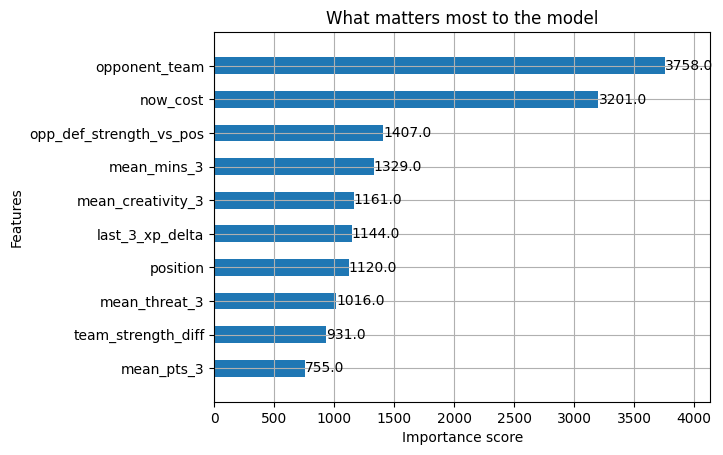

In [8]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10, height=0.5)
plt.title("What matters most to the model")
plt.show()

In [10]:
# 1. Attach predictions to the player names
# We map the index back to the original dataframe to get Names
results = X_test.copy()
results['Name'] = df.loc[X_test.index, 'name']
results['Actual'] = y_test
results['Predicted'] = predictions
results['Error'] = abs(results['Actual'] - results['Predicted'])

# 2. Who does the AI love? (Top Predicted Scorers)
top_picks = results.sort_values(by='Predicted', ascending=False).head(10)
print("--- AI'S DREAM TEAM (Top Predictions) ---")
print(top_picks[['Name', 'opponent_team', 'Predicted', 'Actual', 'Error']])

# 3. Who was the biggest surprise? (Where did the AI fail?)
# This shows us "High Variance" players
surprises = results.sort_values(by='Error', ascending=False).head(5)
print("\n--- BIGGEST MISSES (Unpredictable Hauls) ---")
print(surprises[['Name', 'opponent_team', 'Predicted', 'Actual', 'Error']])

--- AI'S DREAM TEAM (Top Predictions) ---
                  Name  opponent_team  Predicted  Actual     Error
119404   Mohamed Salah        Man Utd  10.092756       7  3.092756
108298   Mohamed Salah  Nott'm Forest   8.363528       2  6.363528
116117   Mohamed Salah         Fulham   8.262262       5  3.262262
116431  Erling Haaland        Man Utd   8.131348       2  6.131348
110475     Cole Palmer  Nott'm Forest   7.814687       6  1.814687
117912   Mohamed Salah      Leicester   7.725492       9  1.274508
110248  Erling Haaland         Fulham   7.525430       2  5.525430
108268  Erling Haaland      Brentford   7.436891      13  5.563109
115139     Bukayo Saka        Man Utd   7.060959       3  4.060959
111658     Cole Palmer      Newcastle   7.044905      10  2.955095

--- BIGGEST MISSES (Unpredictable Hauls) ---
                   Name opponent_team  Predicted  Actual      Error
114099     Kevin Schade     Leicester   1.064635      23  21.935365
109524      Cole Palmer      Brighton  

In [ ]:
# Save the model to the 'src' folder (where the app lives)
model_path = "../src/fpl_model.json"
model.save_model(model_path)
print(f"Model saved to {model_path}")

✅ Model saved to ../src/fpl_model.json
